In [1]:
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Point, Polygon
import contextily as ctx
import shapely.speedups
shapely.speedups.enable()
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import os

In [2]:
# The initial release contains only one tile, so lets hardcode its location
# here.  When you have more tiles, you can update this
TILE_X = 7680
TILE_Y = 10240

In [3]:
address_paths = ['E:\work\canecrushers\lots\Property_address_Queensland_PindiPindi.formatted.geo.json',
                 'E:\work\canecrushers\lots\Property_address_Queensland_Yalboroo.formatted.geo.json']

address_gpd = gpd.GeoDataFrame(
    pd.concat([
        gpd.read_file(path)
            for path in address_paths
    ], sort=False))

address_gpd['ADDRESS_PID'].fillna(address_gpd['ADDRESS_PI'], inplace = True)
address_gpd['LOCAL_AUTHORITY'].fillna(address_gpd['LOCAL_AUTH'], inplace = True)

address_gpd = address_gpd[
                ['LOTPLAN','ADDRESS','LOCAL_AUTHORITY','STATE','ADDRESS_PID','geometry']
            ].astype(
                {'LOCAL_AUTHORITY':'category','STATE':'category'}
            )

address_gpd = gpd.GeoDataFrame(address_gpd)
address_gpd.dtypes

LOTPLAN              object
ADDRESS              object
LOCAL_AUTHORITY    category
STATE              category
ADDRESS_PID          object
geometry             object
dtype: object

In [4]:
address_gpd.head(5)

,LOTPLAN,ADDRESS,LOCAL_AUTHORITY,STATE,ADDRESS_PID,geometry
0,207SP277861,779 Old Bowen Road Pindi Pindi QLD,Mackay Regional,QLD,2764150,POINT (148.74353708 -20.84308611937188)
1,6CI2576,102 Pindi Pindi Blackrock Creek Road Pindi Pin...,Mackay Regional,QLD,2317254,POINT (148.7405187200001 -20.86669204937126)
2,11SP173263,23 Russells Road Pindi Pindi QLD,Mackay Regional,QLD,2020864,POINT (148.73170143 -20.86633068937128)
3,3C124139,81 Old Pindi Bog Road Pindi Pindi QLD,Mackay Regional,QLD,204158,POINT (148.7151944300001 -20.86936320937123)
4,8SP185803,Pindi Pindi Blackrock Creek Road Pindi Pindi QLD,Mackay Regional,QLD,2078657,POINT (148.7413371700001 -20.84620359937182)


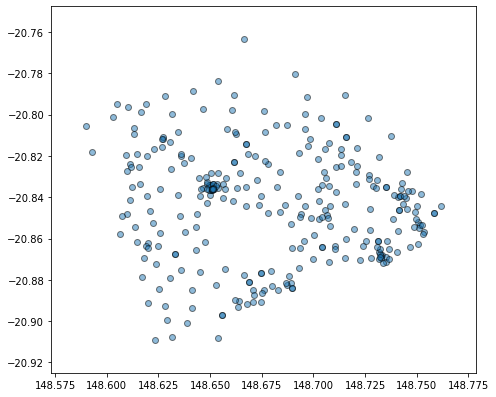

In [5]:
ax = address_gpd.plot(figsize=(7,7), alpha=0.5, edgecolor='k')
plt.tight_layout()

In [6]:
lots_paths = ['E:\work\canecrushers\lots\Cadastral_data_QLD_CADASTRE_DCDB_PindiPindi.formatted.geo.json',
              'E:\work\canecrushers\lots\Cadastral_data_QLD_CADASTRE_DCDB_Yalboroo.formatted.geo.json']

lots_gpd = gpd.GeoDataFrame(
    pd.concat([
        gpd.read_file(lots_path).drop(
            ['LOT_VOLUME','PAR_NUM','ALIAS_NAME','SEG_NUM','LOT','PLAN','PAR_IND','LOT_VOLUME','PARISH','COUNTY','SHIRE_NAME','O_SHAPE_AR','O_SHAPE_LE','LOT_AREA','EXCL_AREA','CA_AREA_SQ','Shape_Leng']
            , axis=1
        ).astype({'SEGPAR':'int32','PRC':'int16','LAC':'int16','LOC':'int16','Shape_Area':'float16','SURV_IND':'category','TENURE':'category','FEAT_NAME':'category','LOCALITY':'category','PARCEL_TYP':'category','COVER_TYP':'category','ACC_CODE':'category'})
            for lots_path in lots_paths
    ]))

lots_gpd.dtypes

LOTPLAN         object
SEGPAR           int32
SURV_IND      category
TENURE          object
PRC              int16
LAC              int16
FEAT_NAME       object
LOC              int16
LOCALITY        object
PARCEL_TYP    category
COVER_TYP     category
ACC_CODE        object
Shape_Area     float16
geometry        object
dtype: object

In [7]:
lots_gpd.head(2)

,LOTPLAN,SEGPAR,SURV_IND,TENURE,PRC,LAC,FEAT_NAME,LOC,LOCALITY,PARCEL_TYP,COVER_TYP,ACC_CODE,Shape_Area,geometry
0,1C124121,37385002,Y,Freehold,6000,4770,NaN,4747,Pindi Pindi,Lot Type Parcel,Base,UPGRADE ADJUSTMENT - 5M,0.000019,POLYGON ((148.7046900470001 -20.84646421699995...
1,87CI2408,37384025,Y,Freehold,6000,4770,NaN,4747,Pindi Pindi,Lot Type Parcel,Base,UPGRADE ADJUSTMENT - 5M,0.000019,POLYGON ((148.6995738820001 -20.87158343899995...


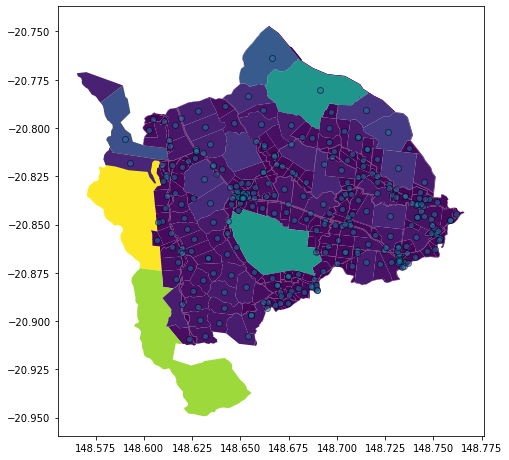

In [8]:
fig, ax = plt.subplots(1, figsize=(7,7))
ax = lots_gpd.plot(ax=ax, column="Shape_Area")
ax = address_gpd.plot(ax=ax, alpha=0.5, edgecolor='k')
plt.tight_layout()

In [9]:
lots_addresses_gpd = gpd.GeoDataFrame(
    pd.merge(lots_gpd, address_gpd, on='LOTPLAN', how='left')
)

lots_addresses_gpd.dtypes

LOTPLAN              object
SEGPAR                int32
SURV_IND           category
TENURE               object
PRC                   int16
LAC                   int16
FEAT_NAME            object
LOC                   int16
LOCALITY             object
PARCEL_TYP         category
COVER_TYP          category
ACC_CODE             object
Shape_Area          float16
geometry_x           object
ADDRESS              object
LOCAL_AUTHORITY    category
STATE              category
ADDRESS_PID          object
geometry_y           object
dtype: object

In [11]:
lots_addresses_gpd[['LOTPLAN','geometry_x','geometry_x']].head(10)

,LOTPLAN,geometry_x,geometry_x
0,1C124121,POLYGON ((148.7046900470001 -20.84646421699995...,POLYGON ((148.7046900470001 -20.84646421699995...
1,87CI2408,POLYGON ((148.6995738820001 -20.87158343899995...,POLYGON ((148.6995738820001 -20.87158343899995...
2,87CI2408,POLYGON ((148.6975011300001 -20.87256289299995...,POLYGON ((148.6975011300001 -20.87256289299995...
3,1CI1966,POLYGON ((148.7349510790001 -20.87118031099993...,POLYGON ((148.7349510790001 -20.87118031099993...
4,1C124121,"POLYGON ((148.703798257 -20.84903004799997, 14...","POLYGON ((148.703798257 -20.84903004799997, 14..."
5,None,POLYGON ((148.7501903770001 -20.83587810399996...,POLYGON ((148.7501903770001 -20.83587810399996...
6,None,"POLYGON ((148.745329745 -20.83831632099998, 14...","POLYGON ((148.745329745 -20.83831632099998, 14..."
7,None,"POLYGON ((148.708265983 -20.86271133299994, 14...","POLYGON ((148.708265983 -20.86271133299994, 14..."
8,2SP173263,"POLYGON ((148.732727788 -20.86516824399996, 14...","POLYGON ((148.732727788 -20.86516824399996, 14..."
9,1RP886048,POLYGON ((148.7481106820001 -20.85854927499997...,POLYGON ((148.7481106820001 -20.85854927499997...


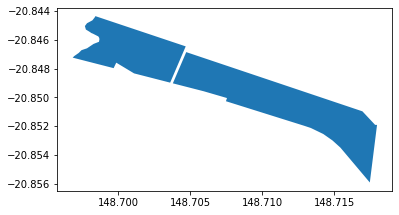

In [12]:
lots_gpd[lots_gpd.LOTPLAN=='1C124121'].plot()

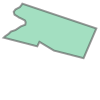

In [13]:
lots_gpd[lots_gpd.LOTPLAN=='1C124121'].geometry[0]

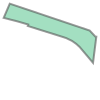

In [14]:
lots_gpd[lots_gpd.LOTPLAN=='1C124121'].geometry[4]

In [15]:
(top, left, bottom, right) = (-20.812410418698178, 148.69443975983441, -20.858263265061037,148.743620498264306)

def px_latlon(top, left, bottom, right, px_width, px_hight):
    """ return array of arrays 
        one array for each pixel (10m X 10 m), containing 
        an array for each spectrum value for the pixel
    """
    
    columns = ['x', 'y', 'lat', 'lon', 'geometry']

    data = []
    for x in range(0, px_width):
        for y in range(0, px_hight):
            lat = left + (right - left) * (x + 0.5) / px_width
            lon = top + (bottom - top) * (y + 0.5) / px_hight
            geometry = Point(lat,lon)

            data.append([x, y, lat, lon, geometry])
    return gpd.GeoDataFrame(columns=columns, data=data) 

In [16]:
pxlatlon = px_latlon(top, left, bottom, right, 512, 512)
pxlatlon.head(2)

,x,y,lat,lon,geometry
0,0,0,148.694488,-20.812455,POINT (148.6944877878993 -20.81245519686846)
1,0,1,148.694488,-20.812545,POINT (148.6944877878993 -20.81254475320901)


In [17]:
pointInPolys = sjoin(pxlatlon, lots_gpd, op='within', how='inner')

In [18]:
pointInPolys.head(2)

,x,y,lat,lon,geometry,index_right,LOTPLAN,SEGPAR,SURV_IND,TENURE,PRC,LAC,FEAT_NAME,LOC,LOCALITY,PARCEL_TYP,COVER_TYP,ACC_CODE,Shape_Area
0,0,0,148.694488,-20.812455,POINT (148.6944877878993 -20.81245519686846),198,2SP115941,61571023,Y,Freehold,6000,4770,NaN,3063,Yalboroo,Lot Type Parcel,Base,UPGRADE ADJUSTMENT - 5M,0.000008
512,1,0,148.694584,-20.812455,POINT (148.694583844029 -20.81245519686846),198,2SP115941,61571023,Y,Freehold,6000,4770,NaN,3063,Yalboroo,Lot Type Parcel,Base,UPGRADE ADJUSTMENT - 5M,0.000008


In [19]:
pointInPolys_df = pd.DataFrame(pointInPolys.drop(['geometry', 'index_right',], axis=1))
pointInPolys_df['tile_x'] = TILE_X
pointInPolys_df['tile_y'] = TILE_Y
pointInPolys_df.head(2)

,x,y,lat,lon,LOTPLAN,SEGPAR,SURV_IND,TENURE,PRC,LAC,FEAT_NAME,LOC,LOCALITY,PARCEL_TYP,COVER_TYP,ACC_CODE,Shape_Area,tile_x,tile_y
0,0,0,148.694488,-20.812455,2SP115941,61571023,Y,Freehold,6000,4770,NaN,3063,Yalboroo,Lot Type Parcel,Base,UPGRADE ADJUSTMENT - 5M,0.000008,7680,10240
512,1,0,148.694584,-20.812455,2SP115941,61571023,Y,Freehold,6000,4770,NaN,3063,Yalboroo,Lot Type Parcel,Base,UPGRADE ADJUSTMENT - 5M,0.000008,7680,10240


In [ ]:
pointInPolys_df.to_parquet(f'points_{TILE_X}_{TILE_Y}.snappy.parquet')